# Setup

In [ ]:
import torch
from torch import nn
import train
import utils
from importlib import reload
reload(train)

train.set_namespace('05-resnet-03')

In [ ]:
train_dl, test_dl, classes = utils.make_cifar_dataloaders_without_validation()

In [ ]:
class BasicBlock(nn.Module):
    """Basic Block for resnet 18 and resnet 34

    """

    #BasicBlock and BottleNeck block
    #have different output size
    #we use class attribute expansion
    #to distinct
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        #residual function
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion)
        )

        #shortcut
        self.shortcut = nn.Sequential()

        #the shortcut output dimension is not the same with residual function
        #use 1*1 convolution to match the dimension
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

class BottleNeck(nn.Module):
    """Residual block for resnet over 50 layers

    """
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, stride=stride, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BottleNeck.expansion, stride=stride, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels * BottleNeck.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

class ResNet(nn.Module):

    def __init__(self, block, num_block, num_classes=100):
        super().__init__()

        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))
        #we use a different inputsize than the original paper
        #so conv2_x's stride is 1
        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        """make resnet layers(by layer i didnt mean this 'layer' was the
        same as a neuron netowork layer, ex. conv layer), one layer may
        contain more than one residual block

        Args:
            block: block type, basic block or bottle neck block
            out_channels: output depth channel number of this layer
            num_blocks: how many blocks per layer
            stride: the stride of the first block of this layer

        Return:
            return a resnet layer
        """

        # we have num_block blocks per layer, the first block
        # could be 1 or 2, other blocks would always be 1
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        output = self.conv3_x(output)
        output = self.conv4_x(output)
        output = self.conv5_x(output)
        output = self.avg_pool(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)

        return output

def resnet18():
    """ return a ResNet 18 object
    """
    return ResNet(BasicBlock, [2, 2, 2, 2])

# Model 1

In [ ]:
model1 = train.Model('resnet-18-01', resnet18(), '40 Adam + 40 SGD')

In [ ]:
with model1.checkpoint(1, '40 Adam without load_best') as cp:
    cp.setup(
        loss_cls=torch.nn.CrossEntropyLoss, 
        optimizer_cls=torch.optim.Adam,
        optimizer_args=dict(lr=5e-4, weight_decay=5e-4),
        epoch_scheduler_cls=torch.optim.lr_scheduler.StepLR, 
        epoch_scheduler_args=dict(step_size=10, gamma=0.2)
    )
    cp.train(train_dl, test_dl, watch='accuracy', load_best=False, epochs=40, metrics=[train.metric_accuracy])
    cp.plot_metrics()


In [ ]:
model1.load_checkpoint(1, from_backup=True)

# Model 1: SGD equivalent

In [ ]:
model1_1 = train.Model('resnet-18-01-01', resnet18(), '40 SGD')

In [ ]:
with model1_1.checkpoint(1, '40 SGD') as cp:
    cp.setup(
        loss_cls=torch.nn.CrossEntropyLoss, 
        optimizer_cls=torch.optim.SGD,
        optimizer_args=dict(lr=0.1, weight_decay=5e-4, momentum=0.9),
        epoch_scheduler_cls=torch.optim.lr_scheduler.StepLR, 
        epoch_scheduler_args=dict(step_size=10, gamma=0.2)
    )
    cp.train(train_dl, test_dl, watch='accuracy', load_best=False, epochs=40, metrics=[train.metric_accuracy])
    cp.plot_metrics()


In [ ]:
with model1_1.checkpoint(2, '40 more SGD') as cp:
    cp.train(train_dl, test_dl, watch='accuracy', load_best=False, epochs=40, metrics=[train.metric_accuracy])
    cp.plot_metrics()


In [ ]:
model1_1.load_checkpoint(1, from_backup=True)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def one_cycle_schedule(total_steps, max_lr, div_factor, final_div_factor, pct_start):
    step1 = int(total_steps * pct_start)
    step2 = total_steps - step1

    # Learning rates for each phase
    lrs1 = np.linspace(max_lr/div_factor, max_lr, step1)
    lrs2 = np.linspace(max_lr, max_lr/div_factor, step2)
    lrs3 = np.linspace(max_lr/div_factor, max_lr/final_div_factor, total_steps - (step1 + step2))
    
    return np.concatenate([lrs1, lrs2, lrs3])

# Parameters for OneCycleLR
total_steps = 1000
pct_start = 0.3
max_lr = 0.01
div_factor = 25
final_div_factor = 1e4

# Compute learning rate schedule
lrs = one_cycle_schedule(total_steps, max_lr, div_factor, final_div_factor, pct_start)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(lrs)
plt.xlabel("Training Steps")
plt.ylabel("Learning Rate")
plt.title("OneCycleLR Learning Rate Schedule")
plt.axvline(x=total_steps*pct_start, color='r', linestyle='--', label="End of Warm-Up")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
t = torch.rand(3, 3)
optim = torch.optim.SGD(params=[t], lr=0.1)
sched = torch.optim.lr_scheduler.OneCycleLR(
    optimizer=optim, 
    total_steps=1000, 
    max_lr=0.1,
    pct_start=0.3,
    anneal_strategy='cos',

)
import pprint
pprint.pprint(sched.state_dict())

lrs = []
momentum = []
for step in range(1000):
    lrs.append(optim.param_groups[0]['lr'])
    momentum.append(optim.param_groups[0]['momentum'])
    sched.step()
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(range(1000), lrs, label='LR')
ax2 = ax.twinx()
ax2.plot(range(1000), momentum, color='red', label='Momentum')
ax.hlines(0.1, xmin=0, xmax=1000, color='black', linestyles='--')
ax.legend(loc='lower left')
ax2.legend(loc='upper right')

In [ ]:
with model1_1.checkpoint(2.2, '80 more SGD') as cp:
    cp.setup(
        epoch_scheduler_cls=torch.optim.lr_scheduler.StepLR, 
        epoch_scheduler_args=dict(step_size=40, gamma=0.2)
    )
    cp.train(train_dl, test_dl, watch='accuracy', load_best=True, epochs=80, metrics=[train.metric_accuracy])
    cp.plot_metrics()


In [ ]:
model1_1.load_checkpoint(1, from_backup=True)

In [ ]:
with model1_1.checkpoint(2.3, '120 more SGD') as cp:
    cp.setup(
        epoch_scheduler_cls=torch.optim.lr_scheduler.MultiStepLR, 
        epoch_scheduler_args=dict(milestones=[40, 60, 80], gamma=0.2)
    )
    cp.train(train_dl, test_dl, watch='accuracy', load_best=True, epochs=120, metrics=[train.metric_accuracy])
    cp.plot_metrics()


# Model 2

In [ ]:
model2 = train.Model('resnet-18-02', resnet18(), '40 Adam with reversion')

In [ ]:
with model2.checkpoint(1) as cp:
    cp.setup(
        loss_cls=torch.nn.CrossEntropyLoss, 
        optimizer_cls=torch.optim.Adam,
        optimizer_args=dict(lr=5e-4, weight_decay=5e-4),
        epoch_scheduler_cls=torch.optim.lr_scheduler.StepLR, 
        epoch_scheduler_args=dict(step_size=10, gamma=0.2)
    )

    cp.train(train_dl, test_dl, watch='accuracy', load_best=True, epochs=10, metrics=[train.metric_accuracy])
    cp.train(train_dl, test_dl, watch='accuracy', load_best=True, epochs=10, metrics=[train.metric_accuracy])
    cp.train(train_dl, test_dl, watch='accuracy', load_best=True, epochs=10, metrics=[train.metric_accuracy])
    cp.train(train_dl, test_dl, watch='accuracy', load_best=True, epochs=10, metrics=[train.metric_accuracy])
    cp.plot_metrics()


In [ ]:
res = model2.cache(1).find_lr(test_dl, optimizer_cls=torch.optim.SGD)
res.plot(end=0.1)

In [ ]:
# DEBUG
id(model2.setup_manager), id(model2.checkpoints[1].setup_manager_copy)

In [ ]:
with model2.checkpoint(2, description='40 SGD') as cp:
    cp.setup(
        optimizer_cls=torch.optim.SGD, 
        optimizer_args=dict(weight_decay=5e-4, momentum=0.9, lr=1e-4),
        epoch_scheduler_cls=torch.optim.lr_scheduler.StepLR, 
        epoch_scheduler_args=dict(step_size=10, gamma=0.2)
    )
    cp.train(train_dl, test_dl, watch='accuracy', load_best=True, epochs=10, metrics=[train.metric_accuracy])
    cp.train(train_dl, test_dl, watch='accuracy', load_best=True, epochs=10, metrics=[train.metric_accuracy])
    cp.train(train_dl, test_dl, watch='accuracy', load_best=True, epochs=10, metrics=[train.metric_accuracy])
    cp.train(train_dl, test_dl, watch='accuracy', load_best=True, epochs=10, metrics=[train.metric_accuracy])
    cp.plot_metrics()

In [ ]:
model2.load_checkpoint(1)

In [ ]:
with model2.checkpoint(3, description='40 SGD (after 40 Adam)') as cp:
    cp.setup(
        optimizer_cls=torch.optim.SGD, 
        optimizer_args=dict(weight_decay=5e-4, momentum=0.9, lr=0.1 * 0.2 ** 2),
        epoch_scheduler_cls=torch.optim.lr_scheduler.StepLR, 
        epoch_scheduler_args=dict(step_size=20, gamma=0.2)
    )
    cp.train(train_dl, test_dl, watch='accuracy', load_best=True, epochs=40, metrics=[train.metric_accuracy])
    cp.plot_metrics()

In [ ]:
with model2.checkpoint(3.1, description='40 SGD (after 40 Adam)') as cp:
    cp.train(train_dl, test_dl, watch='accuracy', load_best=True, epochs=40, metrics=[train.metric_accuracy])
    cp.plot_metrics()

In [ ]:
model2.load_checkpoint(1)

In [ ]:
with model2.checkpoint(4.0, description='40 SGD (after 40 Adam)') as cp:
    cp.setup(
        optimizer_cls=torch.optim.SGD, 
        optimizer_args=dict(weight_decay=5e-4, momentum=0.9, lr=0.1 * 0.2 ** 4),
        epoch_scheduler_cls=torch.optim.lr_scheduler.StepLR, 
        epoch_scheduler_args=dict(step_size=20, gamma=0.2)
    )
    cp.train(train_dl, test_dl, watch='accuracy', load_best=True, epochs=40, metrics=[train.metric_accuracy])
    cp.plot_metrics()

In [ ]:
model2.load_checkpoint(1)

In [ ]:
with model2.checkpoint(5.0, description='160 SGD (after 40 Adam)') as cp:
    cp.setup(
        optimizer_cls=torch.optim.SGD, 
        optimizer_args=dict(weight_decay=5e-4, momentum=0.9, lr=0.1 * 0.2 ** 3),
        epoch_scheduler_cls=torch.optim.lr_scheduler.StepLR, 
        epoch_scheduler_args=dict(step_size=40, gamma=0.2)
    )
    cp.train(train_dl, test_dl, watch='accuracy', load_best=True, epochs=160, metrics=[train.metric_accuracy])
    cp.plot_metrics()

---

In [ ]:
model2.load_checkpoint(1)

# Model 3

In [ ]:
model3 = train.Model('resnet-18-03', resnet18(), '160 SGD')

In [ ]:
with model3.checkpoint(1) as cp:
    cp.setup(
        loss_cls=torch.nn.CrossEntropyLoss, 
        optimizer_cls=torch.optim.SGD, 
        optimizer_args=dict(weight_decay=5e-4, momentum=0.9, lr=0.1),
        epoch_scheduler_cls=torch.optim.lr_scheduler.StepLR, 
        epoch_scheduler_args=dict(step_size=40, gamma=0.2)
    )
    cp.train(train_dl, test_dl, watch='accuracy', load_best=True, epochs=160, metrics=[train.metric_accuracy])
    cp.plot_metrics()

# Model 4

In [ ]:
model4 = train.Model('resnet-18-04', resnet18(), '40 x 4 SGD with reversion')

In [ ]:
with model4.checkpoint(1) as cp:
    cp.setup(
        loss_cls=torch.nn.CrossEntropyLoss, 
        optimizer_cls=torch.optim.SGD, 
        optimizer_args=dict(weight_decay=5e-4, momentum=0.9, lr=0.1),
        epoch_scheduler_cls=torch.optim.lr_scheduler.StepLR, 
        epoch_scheduler_args=dict(step_size=40, gamma=0.2)
    )
    cp.train(train_dl, test_dl, watch='accuracy', load_best=True, epochs=40, metrics=[train.metric_accuracy])
    cp.train(train_dl, test_dl, watch='accuracy', load_best=True, epochs=40, metrics=[train.metric_accuracy])
    cp.train(train_dl, test_dl, watch='accuracy', load_best=True, epochs=40, metrics=[train.metric_accuracy])
    cp.train(train_dl, test_dl, watch='accuracy', load_best=True, epochs=40, metrics=[train.metric_accuracy])
    cp.plot_metrics()

# Model 5

In [ ]:
model5 = train.Model('resnet-18-05', resnet18(), '160 Adam')

In [ ]:
with model5.checkpoint(1) as cp:
    cp.setup(
        loss_cls=torch.nn.CrossEntropyLoss, 
        optimizer_cls=torch.optim.Adam,
        optimizer_args=dict(lr=5e-4, weight_decay=5e-4),
        epoch_scheduler_cls=torch.optim.lr_scheduler.StepLR, 
        epoch_scheduler_args=dict(step_size=40, gamma=0.2)
    )

    cp.train(train_dl, test_dl, watch='accuracy', load_best=True, epochs=160, metrics=[train.metric_accuracy])
    cp.plot_metrics()


# Model 6

In [ ]:
model6 = train.Model('resnet-18-06', resnet18(), 'Testing warmup')

100%|██████████| 157/157 [00:02<00:00, 62.88it/s]


Epoch 2/10: train_loss=3.0017, train_accuracy=0.2475, val_loss=3.1259, val_accuracy=0.2621
Saved model resnet-18-06 checkpoint 1. epoch=2, step=1564. train_loss=3.0017, train_accuracy=0.2475, val_loss=3.1259, val_accuracy=0.2621


100%|██████████| 157/157 [00:02<00:00, 60.87it/s]


Epoch 3/10: train_loss=2.5310, train_accuracy=0.3394, val_loss=2.4929, val_accuracy=0.3510
Saved model resnet-18-06 checkpoint 1. epoch=3, step=2346. train_loss=2.5310, train_accuracy=0.3394, val_loss=2.4929, val_accuracy=0.3510


100%|██████████| 157/157 [00:02<00:00, 60.87it/s]


Epoch 4/10: train_loss=2.2448, train_accuracy=0.4011, val_loss=2.2269, val_accuracy=0.4134
Saved model resnet-18-06 checkpoint 1. epoch=4, step=3128. train_loss=2.2448, train_accuracy=0.4011, val_loss=2.2269, val_accuracy=0.4134


100%|██████████| 157/157 [00:02<00:00, 61.98it/s]


Epoch 5/10: train_loss=2.0501, train_accuracy=0.4441, val_loss=2.0589, val_accuracy=0.4481
Saved model resnet-18-06 checkpoint 1. epoch=5, step=3910. train_loss=2.0501, train_accuracy=0.4441, val_loss=2.0589, val_accuracy=0.4481


100%|██████████| 157/157 [00:02<00:00, 60.52it/s]


Epoch 6/10: train_loss=1.9107, train_accuracy=0.4763, val_loss=2.0137, val_accuracy=0.4592
Saved model resnet-18-06 checkpoint 1. epoch=6, step=4692. train_loss=1.9107, train_accuracy=0.4763, val_loss=2.0137, val_accuracy=0.4592


100%|██████████| 157/157 [00:02<00:00, 59.57it/s]


Epoch 7/10: train_loss=1.8065, train_accuracy=0.5029, val_loss=1.8054, val_accuracy=0.5083
Saved model resnet-18-06 checkpoint 1. epoch=7, step=5474. train_loss=1.8065, train_accuracy=0.5029, val_loss=1.8054, val_accuracy=0.5083


100%|██████████| 157/157 [00:02<00:00, 60.64it/s]


Epoch 8/10: train_loss=1.7150, train_accuracy=0.5225, val_loss=1.8566, val_accuracy=0.4996


100%|██████████| 157/157 [00:02<00:00, 58.91it/s]


Epoch 9/10: train_loss=1.6382, train_accuracy=0.5416, val_loss=1.6578, val_accuracy=0.5375
Saved model resnet-18-06 checkpoint 1. epoch=9, step=7038. train_loss=1.6382, train_accuracy=0.5416, val_loss=1.6578, val_accuracy=0.5375


100%|██████████| 157/157 [00:02<00:00, 60.92it/s]


Epoch 10/10: train_loss=1.5737, train_accuracy=0.5572, val_loss=1.7425, val_accuracy=0.5327
Loaded model resnet-18-06 from checkpoint 1. epoch=9, step=7038. train_loss=1.6382, train_accuracy=0.5416, val_loss=1.6578, val_accuracy=0.5375


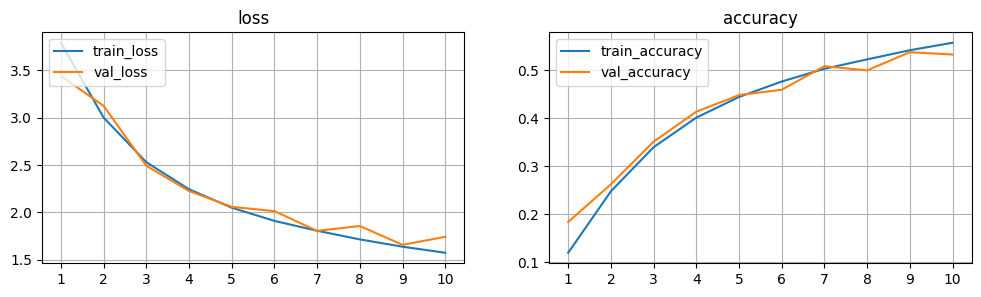

In [37]:
with model6.checkpoint(1) as cp:
    cp.setup(
        loss_cls=torch.nn.CrossEntropyLoss, 
        optimizer_cls=torch.optim.Adam,
        optimizer_args=dict(lr=5e-4, weight_decay=5e-4),
    )

    cp.train(train_dl, test_dl, watch='accuracy', warmup=1, load_best=True, epochs=10, metrics=[train.metric_accuracy])
    cp.plot_metrics()
